## Velocity Potential and Divergent Wind.

#### (or how to make a decent wind plot)

Let us start by importing the usual suspects.

In [12]:
import matplotlib.pyplot   as plt
import cartopy.crs         as ccrs
import cartopy.feature     as cf
import cartopy             as cartopy
import numpy               as np
import xarray              as xr


from cartopy.mpl.ticker    import LongitudeFormatter, LatitudeFormatter
from cartopy.util 		   import add_cyclic_point
from windspharm.xarray 	   import VectorWind  # import Windspharm

The [Windspharm](https://ajdawson.github.io/windspharm/latest/) package allows us to make a number of physical operations from simple horizontal wind gridded datasets. You can check the full list of things you can do [here](https://ajdawson.github.io/windspharm/latest/api/windspharm.xarray.html). 

Windspharm also has a great integration with Xarray, which makes things even better.

In [13]:
##--- read data
wind =  ['uwnd.mon.mean.nc', 
		  'vwnd.mon.mean.nc']

dset  =  xr.open_mfdataset(wind)

uwnd  =  dset['uwnd']

vwnd  =  dset['vwnd']

With [xr.open_mfdataset](http://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html) you can open several files and put them all together in a coherent way, without having to open each one and attribute lots of different variables.

By the way, we're importing both zonal and meridional components of horizontal wind from the [20th Century Reanalysis](https://www.esrl.noaa.gov/psd/data/gridded/data.20thC_ReanV2.pressure.mm.html) set.

In [14]:
lat  =  np.asarray(uwnd['lat'])
lon  =  np.asarray(uwnd['lon'])

With [sel](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.sel.html) from Xarray you can also select a certain pressure level just as you can slice through lat/lon and time.

In [15]:
time1 = '1981-1-1' ; time2 = '2010-12-1'

##--- select level
uwnd  =  uwnd.sel(time=slice(time1,time2),
				  level=200.)
vwnd  =  vwnd.sel(time=slice(time1,time2),
				  level=200.)

With Windspharm you can do complicated operations using spherical harmonics with a single command line. That's the beauty and usefulness of this package.

In [16]:
#--- windspharm call
w  =  VectorWind(uwnd, vwnd)

##--- velocity potential
vp  =  w.velocitypotential()

##--- divergent wind
uchi, vchi  =  w.irrotationalcomponent()

In [22]:
type(vp)

xarray.core.dataarray.DataArray

As you can see, both packages interact quite well. You can make your calculations while using literally everything Xarray can offer, such as the usual monthly averaging.

In [17]:
##--- monthly averaging
vp    =  vp.groupby('time.month').mean('time')
uchi  =  uchi.groupby('time.month').mean('time')
vchi  =  vchi.groupby('time.month').mean('time')

All the needed calculations were already perfomed with quite a few lines of code. Let us now add the cyclic point necessary to drive away that awful [white line](https://github.com/willyhagi/flyingcircus/blob/master/roll_whiteline.ipynb).

In [18]:
##--- add_cyclic_point
lon_idx = vp.dims.index('lon')

vp_c, lon_c   = add_cyclic_point(vp.values, 
								coord=lon, axis=lon_idx)

uchi_c, lon_c = add_cyclic_point(uchi.values, 
								coord=lon, axis=lon_idx)

vchi_c, lon_c = add_cyclic_point(vchi.values, 
								coord=lon, axis=lon_idx)


In [19]:
vp_c  =  vp_c * 1E-6

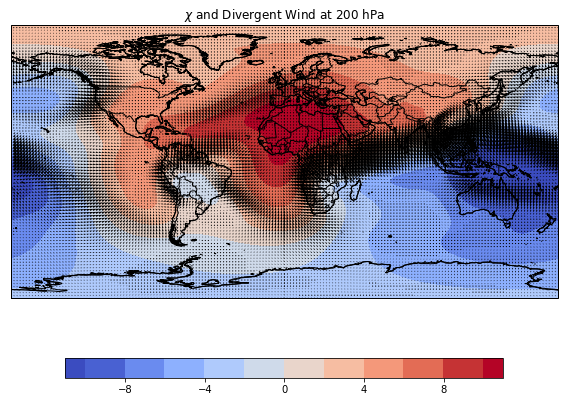

In [25]:
##----------------------- PLOTTING
interc = np.arange(-10,12,2)

##--- DJF velocity potential
plt.figure(figsize=(8,6))
div_int = np.arange(-1.6, 1.8, 0.2)

proj  =  ccrs.PlateCarree(central_longitude=0.)
ax = plt.axes(projection=proj)

ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')

CV = plt.contourf(lon_c, lat, vp_c[0,:,:],
		    interc,
            transform=proj,
            cmap=plt.get_cmap('coolwarm'),
            extend='both')

plt.colorbar(ax=ax, shrink=0.8, 
            orientation='horizontal',
            extendrect=True)


ax.quiver(lon_c, lat, uchi_c[0,:,:], vchi_c[0,:, :])



plt.title(r'$\chi$ and Divergent Wind at 200 hPa')

plt.tight_layout()
plt.show()


Velocity Potential, also denoted as $\chi$, is related to convergence/divergence of the horizontal wind field, while Divergent Wind, also known as $u_{\chi}$ and $v_{\chi}$, is the associated wind flow.

The problem is that you can't see nothing of the Divergent Wind up above, unless of course you have a great sight. Luckily, this can be solved by a small change of the "[quiver](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)" attribute.

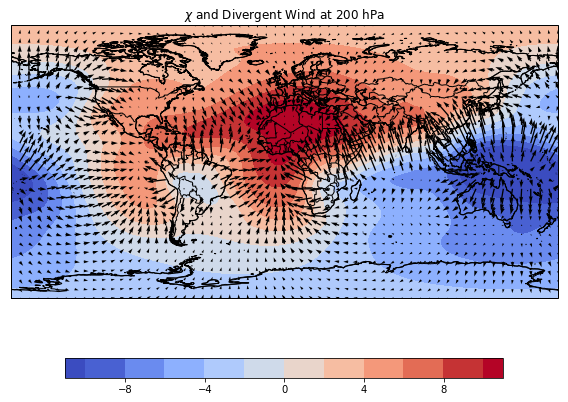

In [28]:
##----------------------- PLOTTING
interc = np.arange(-10,12,2)

##--- DJF velocity potential
plt.figure(figsize=(8,6))
div_int = np.arange(-1.6, 1.8, 0.2)

proj  =  ccrs.PlateCarree(central_longitude=0.)
ax = plt.axes(projection=proj)

ax.add_feature(cf.BORDERS)
ax.add_feature(cf.COASTLINE)
ax.coastlines(resolution='50m',color='black')

CV = plt.contourf(lon_c, lat, vp_c[0,:,:],
		    interc,
            transform=proj,
            cmap=plt.get_cmap('coolwarm'),
            extend='both')

plt.colorbar(ax=ax, shrink=0.8,
             orientation='horizontal',
             extendrect=True)

# magic goes here
ax.quiver(lon_c[::3],
          lat[::3],
          uchi_c[0,::3, ::3], 
          vchi_c[0,::3, ::3])



plt.title(r'$\chi$ and Divergent Wind at 200 hPa')

plt.tight_layout()
plt.show()

So that's it, with a small change of the wind plot parameters you can make things really fit the eye.

Windspharm allows you to make a lot of interesting things, such as locating [Rossby Waves Sources](https://ajdawson.github.io/windspharm/latest/examples/rws_iris.html) from your wind data. The kind of thing you should be worried about instead of the size of your wind vectors.